In [1]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
import os
from langchain_openai import AzureOpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()
embeddings = AzureOpenAIEmbeddings(
openai_api_type="azure",
openai_api_version=os.environ["OPENAI_API_EMBEDDING_VERSION"],
openai_api_key=os.environ["OPENAI_API_EMBEDDING_KEY"],
azure_endpoint=os.environ["AZURE_OPENAI_EMBEDDING_ENDPOINT"],
deployment=os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"],
model=os.environ["AZURE_OPENAI_EMBEDDING_MODEL"],
validate_base_url=True,
)

pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
from langchain.tools.retriever import create_retriever_tool
vector_store = PineconeVectorStore(index=pc.Index("langstuffindex"), embedding=embeddings)

d:\agentagent\AgentAgent\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from langchain.tools.retriever import create_retriever_tool
retriever = vector_store.as_retriever()

In [255]:
stategraph = """
stategraph:
  state:
    OverallState:
      type: TypedDict
      fields:
      - name: input
        type: str
      - name: plan
        type: List[str]
      - name: past_steps
        type: List[Tuple]
      - name: response
        type: str
      - name: messages
        type: Annotated[list[AnyMessage], add_messages]
    config_schema:
      type: TypedDict
      fields:
        llm: str
  nodes:
    - name: START
      function: null
    - name: END
      function: null
    - name: planner
      function: plan_step 
      input_state: OverallState
      output_state: OverallState
      description: "Plan step generates a plan based on the input using llm structured output functionality, stores it to the plan field"
    - name: agent
      function: execute_step
      input_state: OverallState
      output_state: OverallState
      description: "Agent step executes the plan and appends the result to the past_steps field"
    - name: replan
      function: replan_step
      input_state: OverallState
      output_state: OverallState
      description: "Replan step uses structured output llm functionality, if the plan is finished, the step llm returns a Response, else it returns a Plan object."
  edges:
    - from: START
      to: planner
    - from: planner
      to: agent
    - from: agent
      to: replan
  conditional_edges:
    - from: replan
      routing_function: should_end
      mapping:
        END: "If response is present and set in state"
        agent: "If response is not present or set in state"
"""

In [ ]:
from bs4 import BeautifulSoup
import html2text
import httpx

def fetch_documents(url: str) -> str:
    """Fetch a document from a URL and return the markdownified text.

    Args:
        url (str): The URL of the document to fetch.

    Returns:
        str: The markdownified text of the document.
    """
    httpx_client = httpx.Client(follow_redirects=True, timeout=10)

    try:
        response = httpx_client.get(url, timeout=10)
        response.raise_for_status()
        html_content = response
        soup = BeautifulSoup(html_content, 'html.parser')
    
        img_tags = soup.find_all('img')
        for img_tag in img_tags:
            img_tag.decompose()

        target_div = soup.find('div', class_= "theme-doc-markdown markdown") #langchain
        
        if not target_div:
            target_div = soup.find('article') #langraph

        if not target_div:
            target_div = soup.find('html') #langraph

        if not target_div:
            return html2text.html2text(str(soup))
        
        return html2text.html2text(str(target_div))
    except (httpx.HTTPStatusError, httpx.RequestError) as e:
        return f"Encountered an HTTP error: {str(e)}"

In [257]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini")


# AGENT state creation

In [258]:
from pydantic import BaseModel, Field
from langgraph.graph import  MessagesState
class NodeBuilderState(MessagesState):
    """State for the node builder."""
    next: str = Field(description="Next node to go to")
    schema_info: str = Field(description="Schema information about the node")
    input_schema: str = Field(description="Input schema of the node")
    output_schema: str = Field(description="Output schema of the node")
    description: str = Field(description="Description of the node")
    function_name: str = Field(description="Function name of the node")
    code: str = Field(description="Code for the node")
    toolset: list[str] = Field(description="List of tools to be used in the node by the llm")
    node_type : str = Field(description="Type of node, deterministic if the function is deterministic and requires simple python code generation, ai if the function is not deterministic and requires a llm usage for meeting the requirements")
    pass


# NODE type identification and deterministic code gen

In [259]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal
from langchain_core.messages import HumanMessage


class NodeType(BaseModel):
    node_type: Literal["deterministic", "ai"] = Field(description="Type of node, deterministic if the function is deterministic and requires simple python code generation, ai if the function is not deterministic and requires a llm usage for meeting the requirements")


def determine_node_type(state: NodeBuilderState):
    """Determine the type of node."""
    node_type: str = state["node_type"]
    if node_type == "deterministic":
        return "deterministic_code"
    elif node_type == "ai":
        return "ai_node_gen_supervisor"

node_info_prompt= """
You are provided with the following information about the node:
<SchemaInfo>
{schema_info}
</SchemaInfo>
<InputSchema>
{input_schema}
</InputSchema>
<OutputSchema>
{output_schema}
</OutputSchema>
<Description>
{description}
</Description>
<FunctionName>
{function_name}</FunctionName>
"""
    
def identify_node(state: NodeBuilderState):
    """Identify the node and return the information."""
    # Extract the information from the state
    llm_with_structured_output = llm.with_structured_output(NodeType)
    prompt = ChatPromptTemplate.from_template(
        """You are supposed to identify the type of node based on the information provided.
            <SchemaInfo>
            {schema_info}
            </SchemaInfo>
            <InputSchema>
            {input_schema}
            </InputSchema>
            <OutputSchema>
            {output_schema}
            </OutputSchema>
            <Description>
            {description}
            </Description>
            <FunctionName>
            {function_name}
            </FunctionName>
""")
    type_of_node = llm_with_structured_output.invoke(prompt.format(
        schema_info=state["schema_info"],
        input_schema=state["input_schema"],
        output_schema=state["output_schema"],
        description=state["description"],
        function_name=state["function_name"]))
    return {"node_type": type_of_node.node_type, "messages": [HumanMessage(content=node_info_prompt.format(
        schema_info=state["schema_info"],
        input_schema=state["input_schema"],
        output_schema=state["output_schema"],
        description=state["description"],
        function_name=state["function_name"])) ]}

def deterministic_code_gen(state: NodeBuilderState):
    """Generate the code for the node."""
    prompt = ChatPromptTemplate.from_template(
        """Generate the python code for the function {function_name}.
You are provided with the following information about the node:
The schema information is as follows: {schema_info}
The input schema is: {input_schema}
The output schema is: {output_schema}
The description of the function is: {description}

Implement the function to meet the requirements.
""")
    code = llm.invoke(prompt.format(
        schema_info=state["schema_info"],
        input_schema=state["input_schema"],
        output_schema=state["output_schema"],
        description=state["description"],
        function_name=state["function_name"]))
    return {"code": code.content}


# Supervisor creation function

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import  Literal, TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.language_models.chat_models import BaseChatModel


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options] # type: ignore

    def supervisor_node(state: NodeBuilderState) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node


# TOOLSETGEN agent

In [261]:
from langchain_core.messages import HumanMessage

toolset_retriever = create_retriever_tool(retriever, "Retrieve_toolset_information", "Search information about how tools can be added to a langgraph agent, and how to use them.")

toolset_retrieval_prompt = ChatPromptTemplate.from_messages([
         ("system", """
    You are a REact (Reasoning and Act) agent. You are supposed to search for information about how to add tools to a langgraph agent, and how to use them.
    User will provide you with the information of a langgraph node that needs to be implemented, you will analyze the information deeply and suggest tools to be used. 
    Generate python code for the node using the tools you have suggested.
    """),
    ("placeholder", "{messages}"),
    ])
toolset_gen_agent = create_react_agent(llm, tools=[toolset_retriever], prompt = toolset_retrieval_prompt)

def toolset_generation(state: NodeBuilderState) -> Command[Literal["ai_node_gen_supervisor"]]:
    """Generate the code for the node."""
    result = toolset_gen_agent.invoke({"messages": state["messages"]})
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="toolset_suggester")
            ]
        },
        goto="ai_node_gen_supervisor",
    )


# PROMPTGEN agent

In [262]:
from langchain_core.messages import HumanMessage

prompt_vector_store = PineconeVectorStore(index=pc.Index("promptguide"), embedding=embeddings)
prompt_retriever = prompt_vector_store.as_retriever()
prompt_gen_retriever = create_retriever_tool(prompt_retriever, "Retrieve_info_on_prompting", "Search information about what are different prompting techniques relevant to the user requirements.")

promptgen_prompt = ChatPromptTemplate.from_messages([
         ("system", """
    You are tasked with generating a prompt to meet the objectives of the langgraph node.
    The langgraph node information is already provided. 
    
    For example: 
    User query: the node is supposed to generate a plan using llms
    Thought: I need to generate a prompt that will make the LLM generate a plan for the given task.
    Action: Use the  'Retrieve_info_on_prompting' tool to search for plan-and-execute prompting techniques.
    Observation: I found a plan-and-execute prompting technique that can generate a plan for the given task.
    Action: I will customize the observed prompt to meet the requirements of the node.
    """),
    ("placeholder", "{messages}"),
    ])
prompt_gen_agent = create_react_agent(llm, tools=[prompt_gen_retriever], prompt = promptgen_prompt)

def prompt_generation(state: NodeBuilderState) -> Command[Literal["ai_node_gen_supervisor"]]:
    """Generate the code for the node."""
    response = prompt_gen_agent.invoke({"messages": state["messages"]})
    return Command(
        update={
            "messages": [
                HumanMessage(content=response["messages"][-1].content, name="prompt_generator")
            ]
        },
        goto="ai_node_gen_supervisor",
    )


# STRUCTUTRED OUTPUT GEN

In [263]:
struct_output_retriever = create_retriever_tool(retriever, "Retrieve_info_on_structured_output", "Search information about how to use structured output functionality of langchain/llm.")

struc_output_prompt = ChatPromptTemplate.from_messages([
         ("system", """
    You are a REact (Reasoning and Act) agent. You are supposed to search for information about how to use structured output functionality for llms.
    generate code for structured output functionality for the llm to use.
    """),
    ("placeholder", "{messages}"),
    ])

struc_output_agent = create_react_agent(llm, tools=[struct_output_retriever], prompt = struc_output_prompt)

def structured_output_generation(state: NodeBuilderState) -> Command[Literal["ai_node_gen_supervisor"]]:
    """Generate the code for the node."""
    response = struc_output_agent.invoke({"messages": state["messages"]})
    return Command(
        update={
            "messages": [
                HumanMessage(content=response["messages"][-1].content, name="struct_output_generator")
            ]
        },
        goto="ai_node_gen_supervisor",
    )


# Interrupt gen

In [264]:
interrupt_info_retriever = create_retriever_tool(retriever, "Retrieve_info_on_interrupt", "Search information about how to use interrupt functionality in langgraph.")

interrupt_gen_prompt = ChatPromptTemplate.from_messages([
         ("system", """
    You are a REact (Reasoning and Act) agent. You are supposed to search for information about how to use interrupt functionality for langgraph.
    generate code for interrupt functionality.
    """),
    ("placeholder", "{messages}"),
    ])
interrupt_agent = create_react_agent(llm, tools=[interrupt_info_retriever], prompt = interrupt_gen_prompt)

def interrupt_generation(state: NodeBuilderState) -> Command[Literal["ai_node_gen_supervisor"]]:
    """Generate the code for the node."""
    response = struc_output_agent.invoke({"messages": state["messages"]})
    return Command(
        update={
            "messages": [
                HumanMessage(content=response["messages"][-1].content, name="interrupt_generator")
            ]
        },
        goto="ai_node_gen_supervisor",
    )


In [265]:
ai_node_gen_supervisor = make_supervisor_node(llm, ["prompt_generation", "toolset_generation", "structured_output_generation", "interrupt_generation"])

# Graph creation

In [271]:
from langgraph.graph.state import CompiledStateGraph
workflow = StateGraph(NodeBuilderState)
workflow.add_node("identify_node", identify_node)
workflow.add_node("deterministic_code", deterministic_code_gen)

workflow.add_node("ai_node_gen_supervisor", ai_node_gen_supervisor)
workflow.add_node("prompt_generation", prompt_generation)
workflow.add_node("toolset_generation", toolset_generation)
workflow.add_node("structured_output_generation", structured_output_generation)
workflow.add_node("interrupt_generation", interrupt_generation)


workflow.add_edge(START, "identify_node")
workflow.add_conditional_edges("identify_node", determine_node_type, ["deterministic_code", "ai_node_gen_supervisor"])
workflow.add_edge("deterministic_code", END)

app : CompiledStateGraph = workflow.compile()

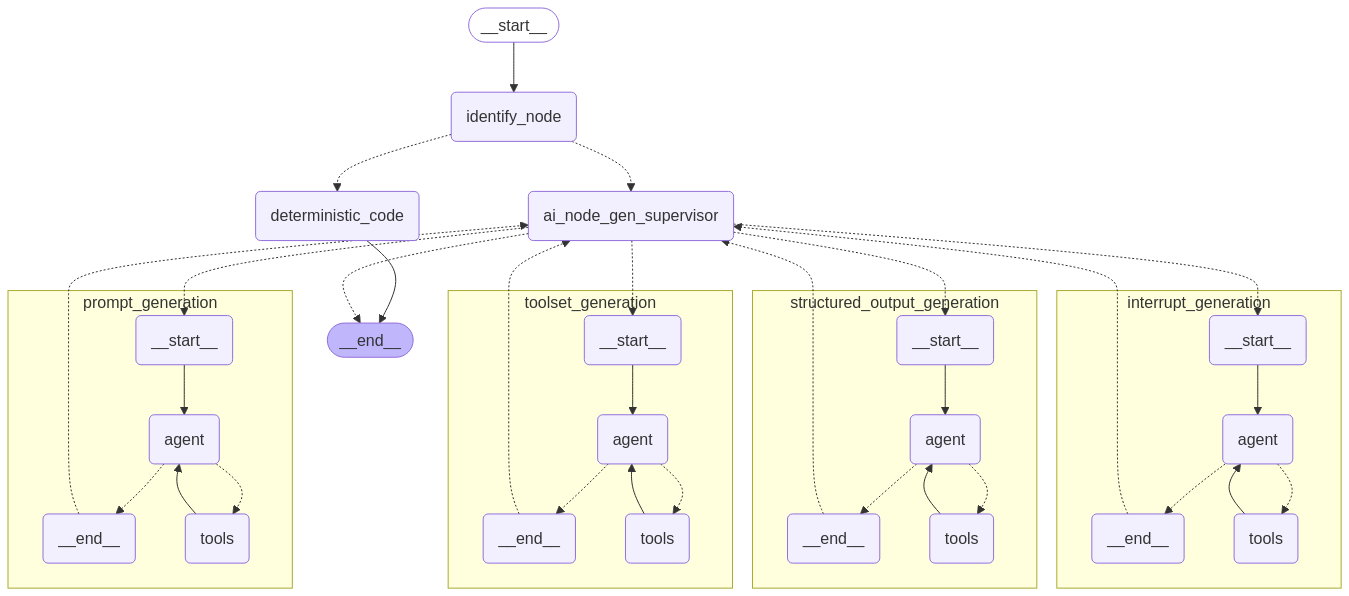

In [248]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [249]:
dict_for_node = {
    "planner": {
        "schema_info": """OverallState:
      type: TypedDict
      fields:
      - name: input
        type: str
      - name: plan
        type: List[str]
      - name: past_steps
        type: List[Tuple]
      - name: response
        type: str
      - name: messages
        type: Annotated[list[AnyMessage], add_messages]""",
    "input_schema": "OverallState",
    "output_schema":"OverallState",
    "description":"Plan step generates a plan based on the input using llm structured output functionality, stores it to the plan field",
    "function_name": "plan_step"
    },
    "math_node":{
        "schema_info": """MathState:
      type: TypedDict
      fields:
      - name: a
        type: int
      - name: b
        type: int
      - name: response
        type: int""",
    "input_schema": "MathState",
    "output_schema":"MathState",
    "description":"Gets the two numbers a and b from the state, and returns the sum of a and b., stores it to the response field",
    "function_name": "math_step"
    }
}

In [252]:
for output in app.stream(dict_for_node["planner"], stream_mode="updates"
    ):
        print(output)

{'identify_node': {'node_type': 'ai', 'messages': [HumanMessage(content='\nYou are provided with the following information about the node:\n<SchemaInfo>\nOverallState:\n      type: TypedDict\n      fields:\n      - name: input\n        type: str\n      - name: plan\n        type: List[str]\n      - name: past_steps\n        type: List[Tuple]\n      - name: response\n        type: str\n      - name: messages\n        type: Annotated[list[AnyMessage], add_messages]\n</SchemaInfo>\n<InputSchema>\nOverallState\n</InputSchema>\n<OutputSchema>\nOverallState\n</OutputSchema>\n<Description>\nPlan step generates a plan based on the input using llm structured output functionality, stores it to the plan field\n</Description>\n<FunctionName>\nplan_step</FunctionName>\n', additional_kwargs={}, response_metadata={}, id='d348520a-5a92-4e9e-b17f-2e87f31e0791')]}}
{'ai_node_gen_supervisor': {'next': 'prompt_generation'}}
{'prompt_generation': {'messages': [HumanMessage(content='Based on the retrieved i